In [1]:
from astropy import constants as const
from scipy.stats import stats
import scipy.integrate as integrate
from scipy.stats import norm
from scipy import interpolate
from astropy.io import fits
from PIL import Image
from astropy.table import Table
from astropy import units as u
from iminuit import Minuit
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pysynphot as S
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'xx-large'
plt.rcParams['ytick.labelsize'] = 'xx-large'

In [2]:
NBBANDS = 6
band_to_number = {'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2 = {'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor = ['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color = {0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number = {'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col = ['b','g','r','y','k']

WLMIN = 3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX = 11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS = int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth = (WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL = np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff = 642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area = Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave = WLMIN, maxwave = WLMAX, num = NBINS, delta = BinWidth, log = False)
S.refs.showref()

EXPOSURE=30.0

pysynphot_root_path = os.environ['PYSYN_CDBS']
path_sed_calspec = os.path.join(pysynphot_root_path,'calspec')

flatsp = S.FlatSpectrum(10, fluxunits='photlam')
flatsp.convert('photlam')
flatsp_norm = flatsp.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))

nbr_filters = 7

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


# Select Spectrum

In [3]:
t = Table.read('table_summary_selectedcalspec.fits')
t

OBJNAME,RA,DEC,SP_TYPE,SP_QUAL,magU,magB,magV,magR,magI,FILES,calcU,calcB,calcV,calcR,calcI,factor,VmI
bytes10,float64,float64,bytes12,bytes1,float64,float64,float64,float64,float64,bytes30,float64,float64,float64,float64,float64,float64,float64
NGC7293,337.411,-20.837,DAO.5,C,11.894,13.158,13.524,13.689,13.898,ngc7293_005.fits,11.917,13.180,13.538,13.734,14.234,26.01,-0.697
G93-48,328.106,2.389,DA2.8,C,11.942,12.732,12.743,12.839,12.938,g93_48_004.fits,11.982,12.717,12.728,12.836,13.234,12.34,-0.506
HZ4,58.842,9.788,DA3.4,C,13.917,14.592,14.506,14.580,14.642,hz4_stis_007.fits,13.923,14.587,14.472,14.561,14.718,61.484,-0.246
HD172167,279.235,38.784,A0Va,C,0.030,0.030,0.030,0.070,0.100,alpha_lyr_stis_010.fits,0.000,0.000,0.000,0.000,0.000,0.0001,0.000
HD163466,268.106,60.396,A2,E,100000000000000000000.000,7.040,6.850,100000000000000000000.000,100000000000000000000.000,hd163466_stis_005.fits,7.143,7.023,6.831,6.685,6.582,0.05399,0.249
HD101452,175.057,-39.147,A2/3(m)A8-F2,E,100000000000000000000.000,7.840,8.200,100000000000000000000.000,100000000000000000000.000,hd101452_stis_002.fits,7.898,7.809,7.508,7.289,7.142,0.10073,0.366
HD106252,183.373,10.042,G0,E,100000000000000000000.000,8.000,100000000000000000000.000,7.000,100000000000000000000.000,hd106252_stis_005.fits,8.101,8.007,7.394,6.948,6.646,0.090687,0.748
FLAT,0.000,0.000,flat,0,9.721,10.369,10.000,9.501,9.001,flat,9.721,10.369,10.000,9.501,9.001,1,0.999


In [4]:
sel_spectrum_idx = 0

In [5]:
if sel_spectrum_idx == 7 :
    
    Spec = flatsp_norm

else :
    Spec = S.FileSpectrum(os.path.join(pysynphot_root_path, 'calspec', t["FILES"][sel_spectrum_idx]))
    
Spec.convert('photlam')

# Cadence LMC

In [6]:
dir_cadences="D:\Projet de recherche\Stage\cadences"
all_my_cadence_files= ["cadence_lmc_baseline2018a_extr_v1.csv",
                      "cadence_lmc_baseline_2snaps_v1_extr_v1.csv",
                      "cadence_lmc_baseline_v1_extr_v1.csv",
                      "cadence_lmc_rolling_nm_scale1_extr_v1.csv",
                      "cadence_lmc_rolling_scale0_extr_v1.csv"
                     ]


dir_atmo = "D:\Projet de recherche\Stage\Atmosphere"
all_my_atmo_files = ["lmc_baseline2018a_extr_v1_atmo.csv",
                     "lmc_baseline_2snaps_v1_extr_v1_atmo.csv",
                     "lmc_baseline_v1_extr_v1_atmo.csv",
                     "lmc_rolling_nm_scale1_extr_v1_atmo.csv",
                     "lmc_rolling_scale0_extr_v1_atmo.csv"
                    ]


dir_fits = "D:\Projet de recherche\Stage"
all_my_fits_files = ["skv20135441655710.fits",
                     "skv20134946561546.fits"
                    ]

dir_LSST = "D:\Projet de recherche\Stage"
LSST_file = "LSST_throughput.csv"

In [7]:
sel_cadence_idx = 0

In [8]:
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df

,observationId,night,observationStartMJD,fiveSigmaDepth,filter,airmass,skyBrightness,seeingFwhmEff,fieldId,fieldRA,fieldDec
0,10033,13,59865.307442,22.042763,y,1.326809,17.868655,0.734701,138,72.000005,-70.933132
1,10158,13,59865.364815,21.847938,y,1.362533,17.829956,0.859026,122,88.568878,-72.896915
2,10160,13,59865.365718,21.894638,y,1.315613,17.861954,0.841153,150,81.777206,-70.757749
3,10161,13,59865.366169,21.944466,y,1.267955,17.897698,0.822736,190,84.972540,-68.155026
4,10166,13,59865.368438,21.905326,y,1.277317,17.874108,0.842751,178,76.364237,-68.470535
...,...,...,...,...,...,...,...,...,...,...,...
752,2371968,3648,63500.338715,23.347211,r,1.338508,20.171447,1.313724,138,72.000005,-70.933132
753,2372034,3648,63500.370822,23.377553,r,1.391936,20.140500,1.252691,122,88.568878,-72.896915
754,2372039,3648,63500.373102,23.480260,r,1.278194,20.210373,1.190228,178,76.364237,-68.470535
755,2372040,3648,63500.373553,23.375525,r,1.328889,20.176793,1.284311,150,81.777206,-70.757749


In [9]:
atmo_file = os.path.join(dir_atmo,all_my_atmo_files[sel_cadence_idx])
df_atmo = pd.read_csv(atmo_file, index_col=0)
df_atmo

,1,2,3,4,5,6,7,8,9,10,...,748,749,750,751,752,753,754,755,756,757
3000,0.006685,0.005863,0.006943,0.008378,0.008064,0.008187,0.006856,0.005650,0.006884,0.008172,...,0.001133,0.001360,0.000911,0.005435,0.005023,0.006416,0.005187,0.008035,0.006637,0.007782
3010,0.011053,0.009818,0.011440,0.013536,0.013081,0.013259,0.011310,0.009497,0.011351,0.013238,...,0.002240,0.002638,0.001839,0.009175,0.008555,0.010648,0.008802,0.013038,0.010981,0.012673
3020,0.016794,0.015079,0.017332,0.020177,0.019565,0.019804,0.017151,0.014633,0.017209,0.019776,...,0.003951,0.004579,0.003300,0.014185,0.013324,0.016233,0.013667,0.019508,0.016694,0.019016
3030,0.027757,0.025246,0.028544,0.032594,0.031731,0.032069,0.028279,0.024593,0.028364,0.032029,...,0.007809,0.008878,0.006663,0.023938,0.022677,0.026935,0.023179,0.031650,0.027611,0.030958
3040,0.033425,0.030548,0.034327,0.038920,0.037945,0.038327,0.034024,0.029800,0.034121,0.038282,...,0.010046,0.011342,0.008639,0.029049,0.027605,0.032483,0.028180,0.037854,0.033258,0.037072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11960,0.970875,0.970113,0.971113,0.972133,0.971932,0.972011,0.971033,0.969915,0.971059,0.972001,...,0.961002,0.961944,0.959724,0.969716,0.969333,0.970625,0.969485,0.971913,0.970830,0.971752
11970,0.970875,0.970113,0.971113,0.972133,0.971932,0.972011,0.971033,0.969915,0.971059,0.972001,...,0.961002,0.961944,0.959724,0.969716,0.969333,0.970625,0.969485,0.971913,0.970830,0.971752
11980,0.952743,0.951572,0.953109,0.954684,0.954373,0.954495,0.952986,0.951267,0.953026,0.954481,...,0.937810,0.939215,0.935917,0.950962,0.950374,0.952359,0.950608,0.954344,0.952674,0.954095
11990,0.952743,0.951572,0.953109,0.954684,0.954373,0.954495,0.952986,0.951267,0.953026,0.954481,...,0.937810,0.939215,0.935917,0.950962,0.950374,0.952359,0.950608,0.954344,0.952674,0.954095


In [10]:
df_LSST = pd.read_csv(os.path.join(dir_LSST, LSST_file), index_col=0)
df_LSST

,wl,u,g,r,i,z,y
0,300,0.000711,0.000000,0.000000,0.000034,0.000000,0.000000
1,301,0.000440,0.000000,0.000000,0.000155,0.000000,0.000000
2,302,0.000591,0.000000,0.000000,0.000072,0.000000,0.000000
3,303,0.000022,0.000000,0.000000,0.000034,0.000000,0.000000
4,304,0.000229,0.000000,0.000000,0.000034,0.000000,0.000000
...,...,...,...,...,...,...,...
896,1196,0.000029,0.000298,0.000088,0.000121,0.000560,0.016426
897,1197,0.000024,0.000357,0.000084,0.000150,0.000630,0.016413
898,1198,0.000016,0.000427,0.000080,0.000187,0.000711,0.016397
899,1199,0.000012,0.000501,0.000076,0.000235,0.000802,0.016303


In [11]:
cadence_file

'D:\\Projet de recherche\\Stage\\cadences\\cadence_lmc_baseline2018a_extr_v1.csv'

In [12]:
df_u = df[df["filter"] == 'u']
df_g = df[df["filter"] == 'g']
df_r = df[df["filter"] == 'r']
df_i = df[df["filter"] == 'i']
df_z = df[df["filter"] == 'z']
df_y = df[df["filter"] == 'y']

In [13]:
#Image.open(r"D:\Projet de recherche\Stage\Skybrightness.png") See Histograms notebook

# Histograms

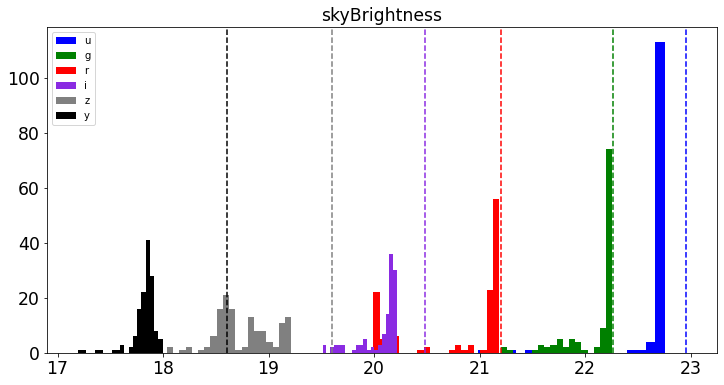

In [14]:
plt.hist(df_u['skyBrightness'], bins = 20, color = 'b', label = 'u');
plt.axvline(22.96, color='b', linestyle='dashed')
plt.hist(df_g['skyBrightness'], bins = 20, color = 'g', label = 'g');
plt.axvline(22.26, color='g', linestyle='dashed')
plt.hist(df_r['skyBrightness'], bins = 20, color = 'r', label = 'r');
plt.axvline(21.20, color='r', linestyle='dashed')
plt.hist(df_i['skyBrightness'], bins = 20, color = 'blueviolet', label = 'i');
plt.axvline(20.48, color='blueviolet', linestyle='dashed')
plt.hist(df_z['skyBrightness'], bins = 20, color = 'grey', label = 'z');
plt.axvline(19.60, color='grey', linestyle='dashed')
plt.hist(df_y['skyBrightness'], bins = 20, color = 'k', label = 'y');
plt.axvline(18.61, color='k', linestyle='dashed')
plt.title("skyBrightness")
plt.legend()

## Dashed line = expected skyBrightness value at zenith, in dark sky

Text(0.5, 0, 'fieldId')

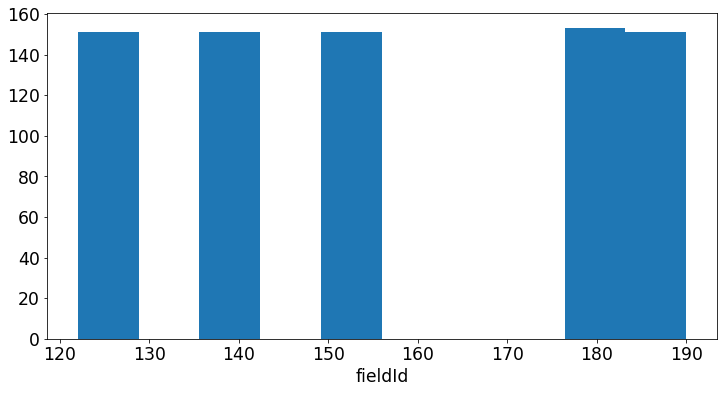

In [15]:
plt.hist(df["fieldId"]);
plt.xlabel("fieldId")

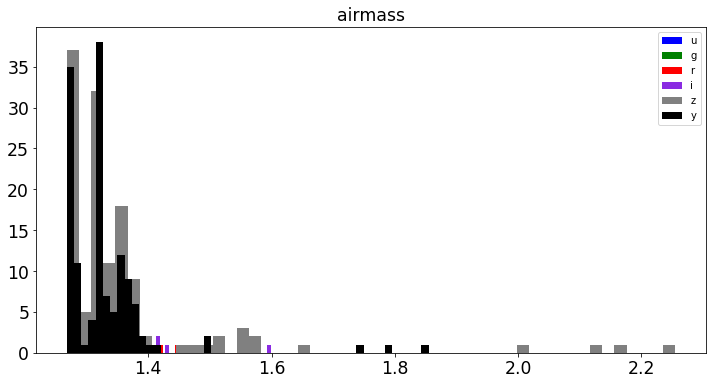

In [16]:
plt.hist(df_u["airmass"], bins = 50, color = 'b', label = 'u');
plt.hist(df_g["airmass"], bins = 50, color = 'g', label = 'g');
plt.hist(df_r["airmass"], bins = 50, color = 'r', label = 'r');
plt.hist(df_i["airmass"], bins = 50, color = 'blueviolet', label = 'i');
plt.hist(df_z["airmass"], bins = 50, color = 'grey', label = 'z');
plt.hist(df_y["airmass"], bins = 50, color = 'k', label = 'y');
plt.title("airmass")
plt.legend()

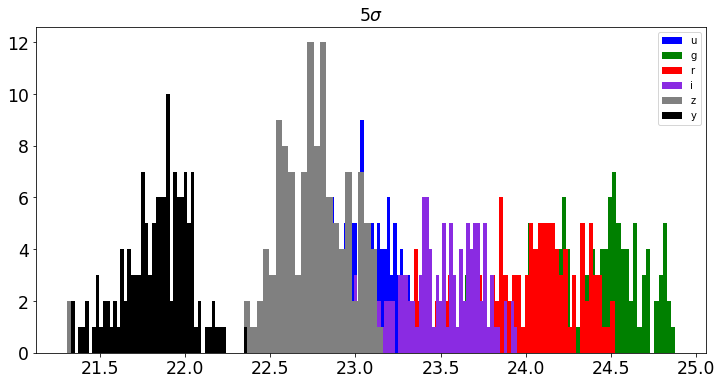

In [17]:
plt.hist(df_u["fiveSigmaDepth"], bins = 50, color = 'b', label = 'u');
plt.hist(df_g["fiveSigmaDepth"], bins = 50, color = 'g', label = 'g');
plt.hist(df_r["fiveSigmaDepth"], bins = 50, color = 'r', label = 'r');
plt.hist(df_i["fiveSigmaDepth"], bins = 50, color = 'blueviolet', label = 'i');
plt.hist(df_z["fiveSigmaDepth"], bins = 50, color = 'grey', label = 'z');
plt.hist(df_y["fiveSigmaDepth"], bins = 50, color = 'k', label = 'y');
plt.title("$5\sigma$")
plt.legend()

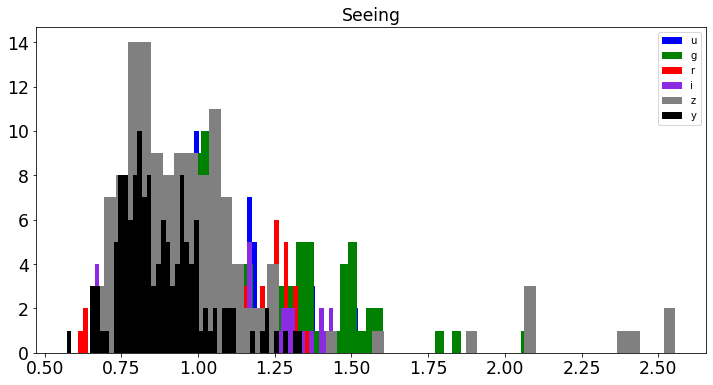

In [18]:
plt.hist(df_u["seeingFwhmEff"], bins = 50, color = 'b', label = 'u');
plt.hist(df_g["seeingFwhmEff"], bins = 50, color = 'g', label = 'g');
plt.hist(df_r["seeingFwhmEff"], bins = 50, color = 'r', label = 'r');
plt.hist(df_i["seeingFwhmEff"], bins = 50, color = 'blueviolet', label = 'i');
plt.hist(df_z["seeingFwhmEff"], bins = 50, color = 'grey', label = 'z');
plt.hist(df_y["seeingFwhmEff"], bins = 50, color = 'k', label = 'y');
plt.title("Seeing")
plt.legend()

# t0 distribution

Wall time: 2.43 s


Text(0.5, 1.0, 'Distribution des $t_0$')

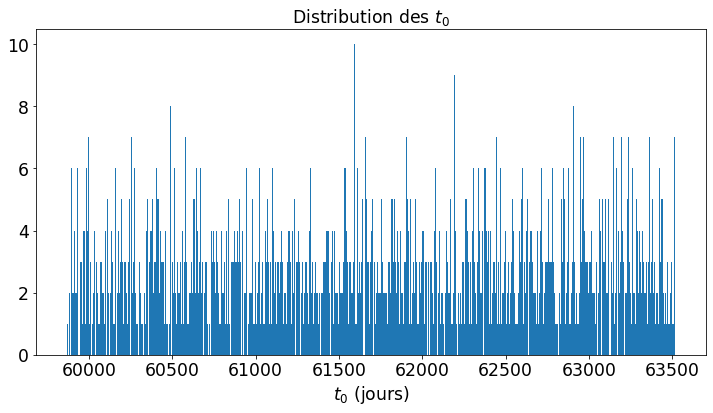

In [19]:
%%time

from scipy.stats import uniform

NYEARS = 10
NDAYS = NYEARS*365.25

xmin = 0
xmax = NDAYS
N=10000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N) + df['observationStartMJD'][0]

plt.hist(list_t0,bins=int(NDAYS));
plt.xlabel("$t_0$ (jours)")
plt.title("Distribution des $t_0$")

# u0 distribution

Text(0.5, 1.0, '$u_{min}$ distribution')

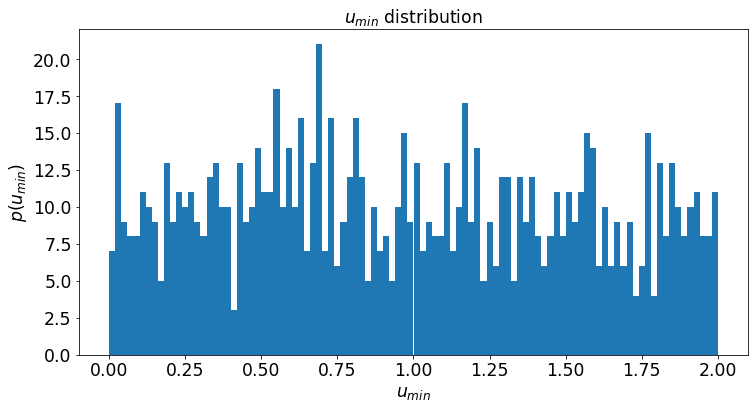

In [20]:
N = 1000
uminmin = 0
uminmax = 2
umin = uniform.rvs(uminmin,uminmax,N)

plt.hist(umin,bins=100)
plt.xlabel("$u_{min}$")
plt.ylabel("$p(u_{min})$")
plt.title("$u_{min}$ distribution")

# Define LMC coordinates

In [21]:
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad

In [22]:
result_table = Simbad.query_object("lmc")

In [23]:
galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
print(galaxy_ra,galaxy_dec)

80.89416666666666 -69.75611111111111


### 

 - We only keep data points in a 3.5° field around the center of the LMC

In [24]:
from photutils.aperture import SkyCircularAperture
from regions import CircleSkyRegion

positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg').galactic
aper = SkyCircularAperture(positions, 3.5/2 * u.deg)
Circle = CircleSkyRegion(positions, 3.5/2 * u.deg)

In [25]:
data_coords = []
data_coords_u = []
data_coords_g = []
data_coords_r = []
data_coords_i = []
data_coords_z = []
data_coords_y = []
gal_u = []
gal_g = []
gal_r = []
gal_i = []
gal_z = []
gal_y = []

for i in range (len(df['observationStartMJD'])) :
    
    data_coords.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
    
    if (df["filter"][i] == "u") :
        
        data_coords_u.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_u.append(data_coords[i].galactic)
   
    elif (df["filter"][i] == "g") :
        
        data_coords_g.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_g.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "r") :
        
        data_coords_r.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_r.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "i") :
        
        data_coords_i.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_i.append(data_coords[i].galactic)
           
    elif (df["filter"][i] == "z") :
        
        data_coords_z.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_z.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "y") :
        
        data_coords_y.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_y.append(data_coords[i].galactic)
        

# Sky map of the data points in galactic coordinates 

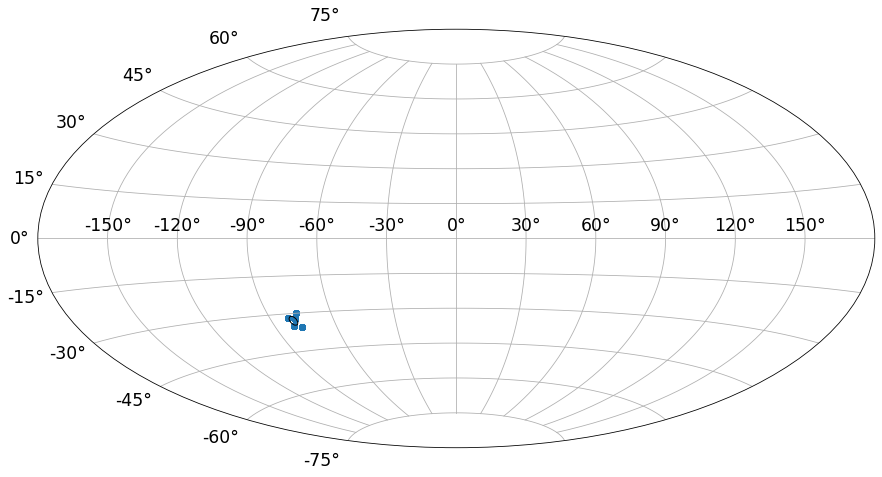

In [26]:
Circle_1 = plt.Circle((positions.l.wrap_at('180d').radian, positions.b.radian), 3.5*np.pi/180/2, fill = False)
gal = SkyCoord(df['fieldRA'], df['fieldDec'], unit='deg').galactic
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(projection='aitoff')
ax.add_patch(Circle_1)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, color='C0', alpha=1, marker='o')
plt.grid();

# Sky map of the data points in galactic coordinates (with colors for each filter)

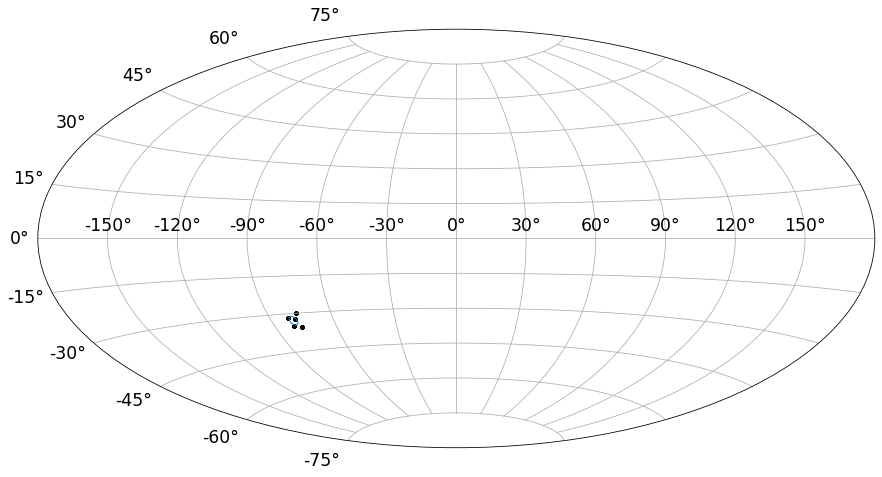

In [27]:
fig = plt.figure(figsize=(15, 10))
Circle_1 = plt.Circle((positions.l.wrap_at('180d').radian, positions.b.radian), 3.5*np.pi/180/2, fill = False, color ='C0')
ax = plt.subplot(projection='aitoff')
ax.add_patch(Circle_1)

for i in range (len(gal_u)) :

    plt.scatter(gal_u[i].l.wrap_at('180d').radian, gal_u[i].b.radian, color ='b', alpha=1, marker='.')
    
for i in range (len(gal_g)) :
    
    plt.scatter(gal_g[i].l.wrap_at('180d').radian, gal_g[i].b.radian, color = "g", alpha=1, marker='.')
    
for i in range (len(gal_r)) :
    
    plt.scatter(gal_r[i].l.wrap_at('180d').radian, gal_r[i].b.radian, color = "r", alpha=1, marker='.')
    
for i in range (len(gal_i)) :
    
    plt.scatter(gal_i[i].l.wrap_at('180d').radian, gal_i[i].b.radian, color = "blueviolet", alpha=1, marker='.')
    
for i in range (len(gal_z)) :
    
    plt.scatter(gal_z[i].l.wrap_at('180d').radian, gal_z[i].b.radian, color = "grey", alpha=1, marker='.')
    
for i in range (len(gal_y)) :
    
    plt.scatter(gal_y[i].l.wrap_at('180d').radian, gal_y[i].b.radian, color = "k", alpha=1, marker='.')

plt.grid();

In [28]:
from astropy.wcs import WCS

In [29]:
File = fits.open(os.path.join(dir_fits, all_my_fits_files[0]))

image = File[0].data
header = File[0].header
wcs = WCS(header)

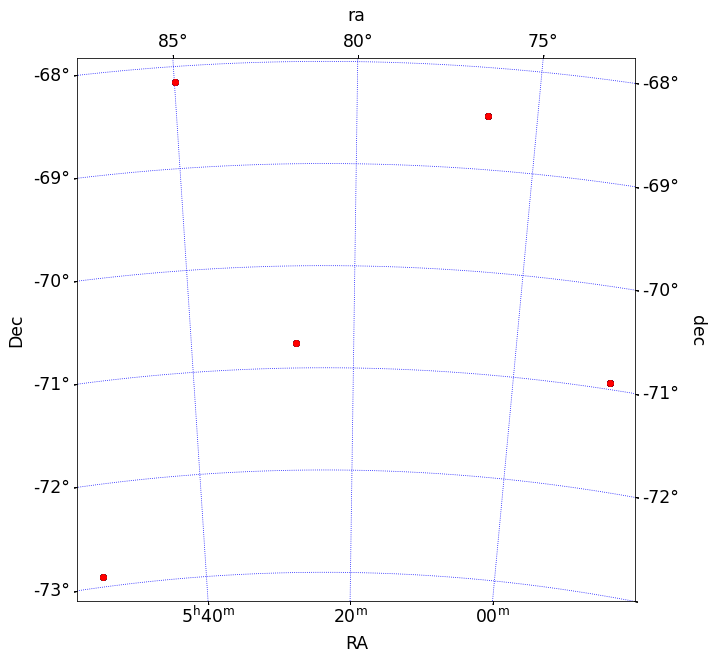

In [30]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection = wcs)
#plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')
#Circle_2 = plt.Circle((galaxy_ra, galaxy_dec), 3.5, fill = False, color ='C0')
#ax.add_patch(Circle_2)

for i in range (len(df['observationId'])) :

    if (df['filter'][i] == "u") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='o')
        
    if (df['filter'][i] == "g") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='o')
        
    if (df['filter'][i] == "r") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='o')
        
    if (df['filter'][i] == "i") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='o')
        
    if (df['filter'][i] == "z") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='o')
        
    if (df['filter'][i] == "y") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='o')
    
#ax.plot_coord(SkyCoord(galaxy_ra * u.deg, galaxy_dec * u.deg), marker = 'o')   
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='blue', ls='dotted')

In [31]:
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
len(df_good)

151

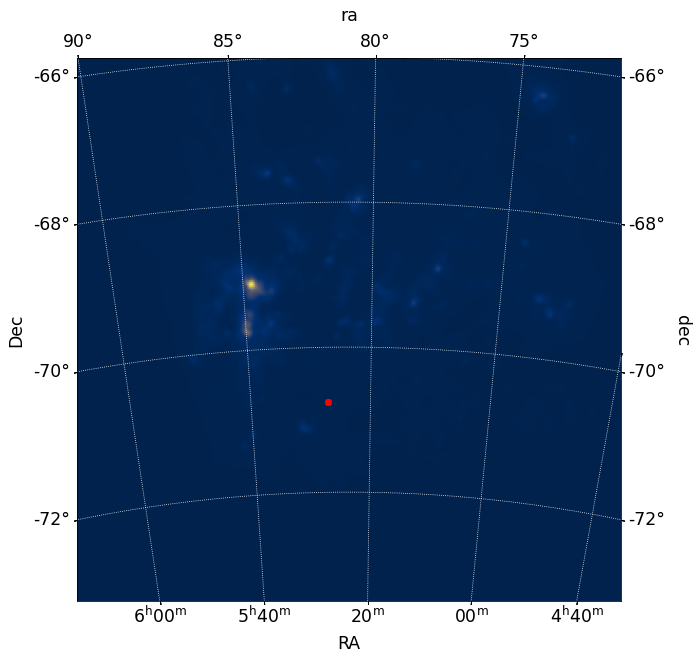

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection = wcs)
plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')   
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')


for i in range (len(df['observationId'])) :

    if (df['filter'][i] == 'u' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='o')
        
    if (df['filter'][i] == 'g' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='o')
        
    if (df['filter'][i] == 'r' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='o')
        
    if (df['filter'][i] == 'i' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value*2**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='o')
        
    if (df['filter'][i] == 'z' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='o')
        
    if (df['filter'][i] == 'y' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='o')
        
# 7.5° image

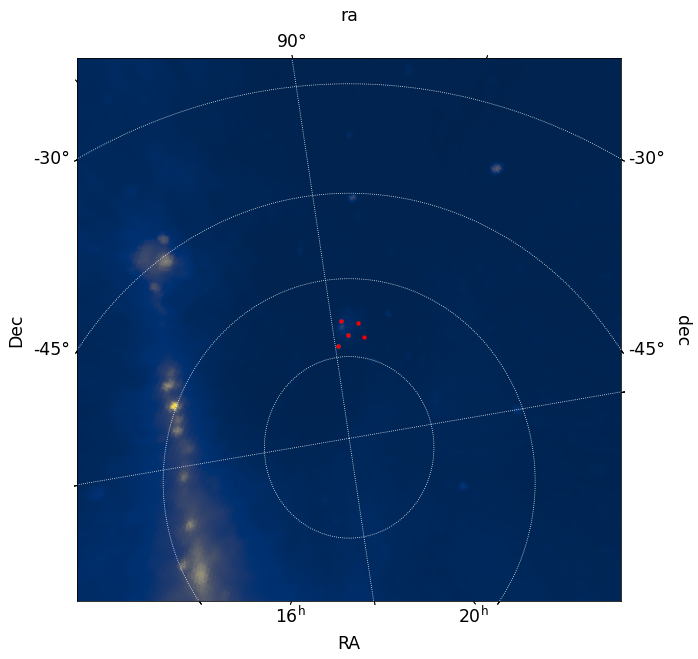

In [33]:
File_big = fits.open(os.path.join(dir_fits, all_my_fits_files[1]))

image_big = File_big[0].data
header_big = File_big[0].header
wcs_big = WCS(header_big)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection = wcs_big)
plt.imshow(image_big, origin='lower', cmap='cividis', aspect='equal')   
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')


for i in range (len(df['observationId'])) :

    if (df['filter'][i] == 'u' ):
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='.')
        
    if (df['filter'][i] == 'g'  ):
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='.')
        
    if (df['filter'][i] == 'r'  ):
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='.')
        
    if (df['filter'][i] == 'i'  ):
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='.')
        
    if (df['filter'][i] == 'z' ) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='.')
        
    if (df['filter'][i] == 'y')  :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='.')

# Plot of the data points coordinates (RA, Dec) and the LSST field of view ( 3.5° circle around the center of the LMC)

Text(0, 0.5, 'Declination')

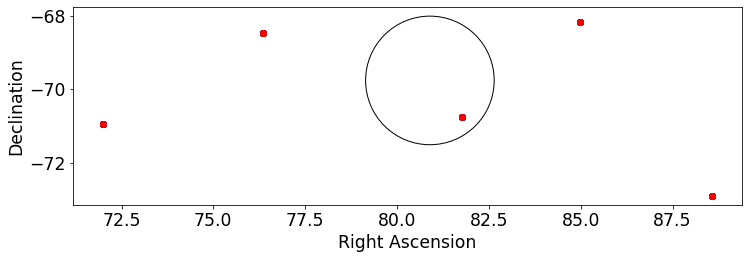

In [34]:
Circle_3 = plt.Circle((galaxy_ra, galaxy_dec), 3.5/2, fill = False)
fig, ax = plt.subplots() 

for i in range (len(df['observationStartMJD'])) :
    
    if (df["filter"][i] == "u") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'b', marker = 'o')
   
    elif (df["filter"][i] == "g") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'g', marker = 'o')
        
    elif (df["filter"][i] == "r") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'r', marker = 'o')
        
    elif (df["filter"][i] == "i") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'blueviolet', marker = 'o')
           
    elif (df["filter"][i] == "z") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'grey', marker = 'o')
        
    elif (df["filter"][i] == "y") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'k', marker = 'o')
        


ax.add_patch(Circle_3)
ax.set_aspect("equal")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

# We only keep the data points inside the LSST field of view  

Text(0, 0.5, 'Declination')

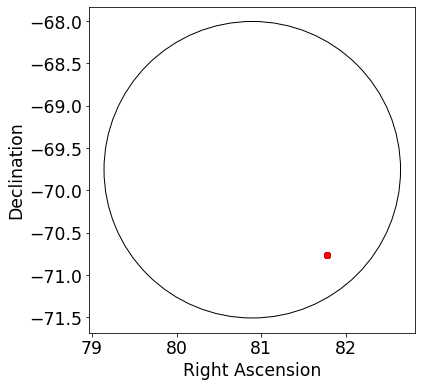

In [35]:
Circle_3 = plt.Circle((galaxy_ra, galaxy_dec), 3.5/2, fill = False)
fig, ax = plt.subplots() 

for i in range (len(df_good['observationStartMJD'])) :
    
    if (df_good["filter"].values[i] == "u") :
        
        plt.scatter(df_good["fieldRA"].values[i], df_good['fieldDec'].values[i], color = 'b', marker = 'o')
   
    elif (df_good["filter"].values[i] == "g") :
        
        plt.scatter(df_good["fieldRA"].values[i], df_good['fieldDec'].values[i], color = 'g', marker = 'o')
        
    elif (df_good["filter"].values[i] == "r") :
        
        plt.scatter(df_good["fieldRA"].values[i], df_good['fieldDec'].values[i], color = 'r', marker = 'o')
        
    elif (df_good["filter"].values[i] == "i") :
        
        plt.scatter(df_good["fieldRA"].values[i], df_good['fieldDec'].values[i], color = 'blueviolet', marker = 'o')
           
    elif (df_good["filter"].values[i] == "z") :
        
        plt.scatter(df_good["fieldRA"].values[i], df_good['fieldDec'].values[i], color = 'grey', marker = 'o')
        
    elif (df_good["filter"].values[i] == "y") :
        
        plt.scatter(df_good["fieldRA"].values[i], df_good['fieldDec'].values[i], color = 'k', marker = 'o')
        
ax.add_patch(Circle_3)
ax.set_aspect("equal")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

# Relative angular source-lens separation u(t)

$$ 
   u(t) = \sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2)}
$$




In [36]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

# Amplitude as a function of u(t)

$$
    A(u) = \frac{u^2 + 2}{u\sqrt{u^2 + 4}}
$$

In [37]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

# Amplitude as a function of u0, t0, tE

$$
    A(t, u_0, t_0, t_E) = \frac{u_{0}^2 + (\frac{t-t_0}{t_E})^2) + 2}{\sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2)} \sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2) + 4}}
$$

In [38]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4) 

# Gaussian

$$
    y = \frac{A}{\sigma \sqrt{2\pi}} e^{\frac{-(x - \mu)^2}{2\sigma^2}}
$$

In [39]:
#Gaussian fit

def Gauss(x, A, mu ,sigma) :
    return A*np.exp(-(x-mu)**2/(2*sigma**2))/sigma/np.sqrt(2*np.pi)

# Linear 

$$
    y = \alpha x + \beta
$$


In [40]:
#Linear fit

def linear(x, alpha, beta) : 
    return alpha*x + beta

# Plotting the light curve and Microlensing fit with arbitrary errors

t0 = 61052.79964751418
tE = 20
u0 = 1.2155977494518981


(60952.79964751418, 61152.79964751418)

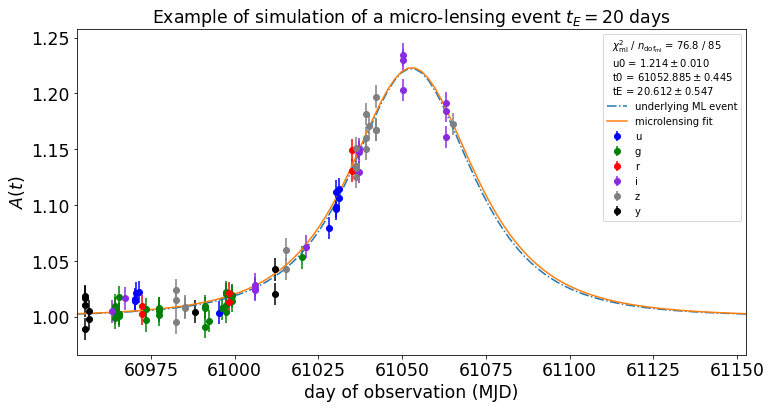

In [41]:
#Randomize parameters

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 20

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Plot

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")
#plt.scatter(df_event_times,A(u(df_event_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_u_times,A(u(df_event_u_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_g_times,A(u(df_event_g_times)),marker="o",s=20,color = "g",label="g")
#plt.scatter(df_event_r_times,A(u(df_event_r_times)),marker="o",s=20,color = "r",label="r")
#plt.scatter(df_event_i_times,A(u(df_event_i_times)),marker="o",s=20,color ="blueviolet",label="i")
#plt.scatter(df_event_z_times,A(u(df_event_z_times)),marker="o",s=20,color ="grey",label="z")
#plt.scatter(df_event_y_times,A(u(df_event_y_times)),marker="o",s=20,color="k",label="y")

# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

y_noise = 0.01

y = y_data + y_noise * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + y_noise * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + y_noise * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + y_noise * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + y_noise * np.random.randn(len(x_i)) 
y_z = A(u(df_event_times_z)) + y_noise * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + y_noise * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, y_noise, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, y_noise, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, y_noise, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, y_noise, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, y_noise, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, y_noise, fmt="o", label="y", color ="k")

least_squares = LeastSquares(x, y, y_noise, Ab)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Ab(ti, *m.values), label="microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

# Linear fit

(60952.79964751418, 61152.79964751418)

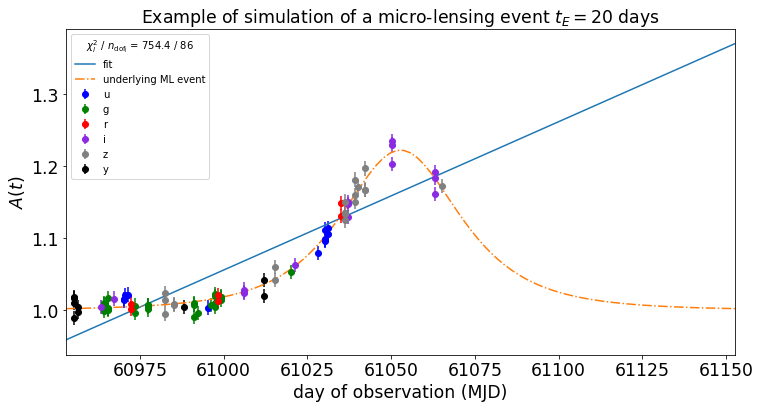

In [42]:
least_squares_line = LeastSquares(x, y, y_noise, linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, y_noise, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, y_noise, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, y_noise, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, y_noise, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, y_noise, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, y_noise, fmt="o", label="y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label="fit")
plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [43]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit)) 

51.96827760244156

# Test error on magnitude

In [44]:

m = 20
xerr = []
sigma_sys = 0.003
error_photo = []


for i in range (len(df)) :
    
    xerr.append( 10**(0.4*(m - df["fiveSigmaDepth"][i])))
    
    if (df["filter"][i] == "u") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.037) * xerr[i] + 0.037 * xerr[i]**2))  
   
    elif (df["filter"][i] == "g") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.038) * xerr[i] + 0.038 * xerr[i]**2))  
        
    elif (df["filter"][i] == "r") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))  
        
    elif (df["filter"][i] == "i") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))      
           
    elif (df["filter"][i] == "z") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))     
        
    elif (df["filter"][i] == "y") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))
        


# Photo error as a function of magnitude

Text(0.5, 1.0, 'Photometric error as a function of magnitude')

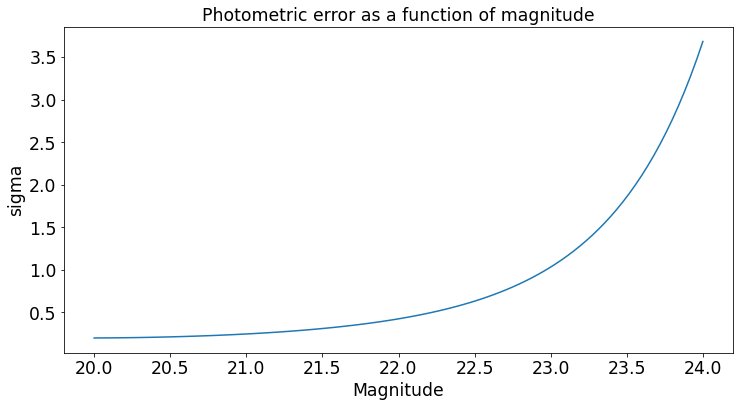

In [45]:
mag = np.linspace(20,24,100)
sigma = []

for i in range (len(mag)) :
    
    sigma.append(np.sqrt(sigma_sys**2 + (0.04 - 0.037) * 10**(0.4*(mag[i] - 20)) + 0.037 * 10**(0.4*(mag[i] - 20))**2))

    
plt.plot(mag,sigma)
plt.xlabel("Magnitude")
plt.ylabel("sigma")
plt.title("Photometric error as a function of magnitude")
#plt.text(x = 21, y = 3, s = "Low magnitude/Bright source means high photometric error", fontsize = 15, color = 'r')

# Background noise

$$
    F_b = F_{ab}10^{-0.4m_b} \times \pi \theta_{seeing}^2 
$$

$$
     F_{ab} = 3631 Jy = 3631\times10^{-23} erg.s^{-1}.Hz^{-1}.cm^{-2} = 3631\times10^{-26} W.Hz^{-1}.m^{-2}
$$

$$
    N_{pe}^b = \frac{\pi D^2 \Delta T}{4h}F_b \int_{}^{} T^{syst}_b(\lambda) \,\frac{d\lambda}{\lambda} 
$$

In [46]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)

In [47]:
ObservationStartMJD_u = []
ObservationStartMJD_g = []
ObservationStartMJD_r = []
ObservationStartMJD_i = []
ObservationStartMJD_z = []
ObservationStartMJD_y = []

for i in range (len(df["observationId"])) :
    
    if (df['filter'][i] == 'u') :
            
            ObservationStartMJD_u.append(df["observationStartMJD"].values[i])
    
    if (df['filter'][i] == 'g') :
            
            ObservationStartMJD_g.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'r') :
            
            ObservationStartMJD_r.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'i') :
            
            ObservationStartMJD_i.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'z') :
            
            ObservationStartMJD_z.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'y') :
        
            ObservationStartMJD_y.append(df["observationStartMJD"].values[i])

In [48]:
from astropy import units as u

D = Deff
Delta_T = EXPOSURE
F_ab = 3631*10**(-23) * u.erg/u.s/u.Hz/u.cm**2

In [49]:
F_ab.to(u.jansky)

<Quantity 3631. Jy>

In [50]:
H = S.units.H * (u.erg * u.s)
H

<Quantity 6.6262e-27 erg s>

In [51]:
F_b = []
F_b_u = []
F_b_g = []
F_b_r = []
F_b_i = []
F_b_z = []
F_b_y = []

for i in range (len(df["observationId"])) :
    
    F_b.append(F_ab * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
    
    if (df['filter'][i] == 'u') :
            
            F_b_u.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
    
    if (df['filter'][i] == 'g') :
            
            F_b_g.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'r') :
            
            F_b_r.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'i') :
            
            F_b_i.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'z') :
            
            F_b_z.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'y') :
        
            F_b_y.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))

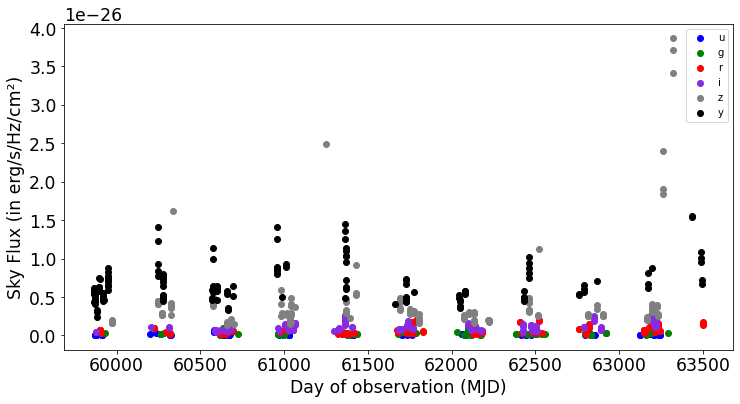

In [52]:
plt.scatter(ObservationStartMJD_u, F_b_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, F_b_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, F_b_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, F_b_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, F_b_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, F_b_y, color = 'k', label = 'y')
plt.ylabel("Sky Flux (in erg/s/Hz/cm²)")
plt.xlabel("Day of observation (MJD)")
plt.legend()

In [53]:
N_pe = []
N_pe_u = []
N_pe_g = []
N_pe_r = []
N_pe_i = []
N_pe_z = []
N_pe_y = []

for i in range (len(F_b)) :
    
    if (df['filter'][i] == 'u') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_u.throughput/Wavelength))
            N_pe_u.append(N_pe[i])
    
    if (df['filter'][i] == 'g') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_g.throughput/Wavelength))
            N_pe_g.append(N_pe[i])
            
    if (df['filter'][i] == 'r') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_r.throughput/Wavelength))
            N_pe_r.append(N_pe[i])
            
    if (df['filter'][i] == 'i') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_i.throughput/Wavelength))
            N_pe_i.append(N_pe[i])
            
    if (df['filter'][i] == 'z') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_z.throughput/Wavelength))
            N_pe_z.append(N_pe[i])
            
    if (df['filter'][i] == 'y') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_y.throughput/Wavelength))
            N_pe_y.append(N_pe[i])


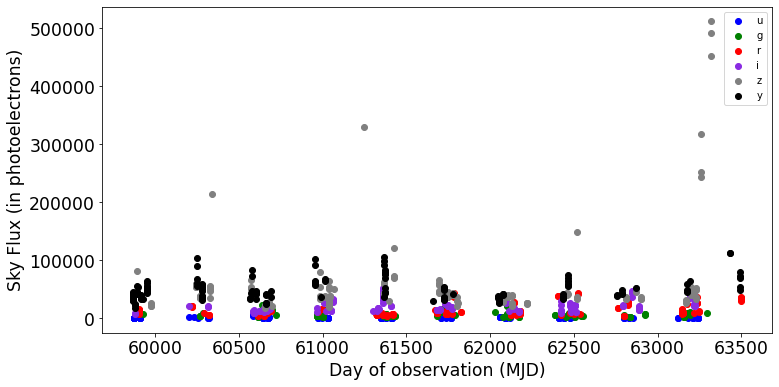

In [54]:
plt.scatter(ObservationStartMJD_u, N_pe_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, N_pe_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, N_pe_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, N_pe_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, N_pe_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, N_pe_y, color = 'k', label = 'y')
plt.ylabel("Sky Flux (in photoelectrons)")
plt.xlabel("Day of observation (MJD)")
plt.legend()

In [55]:
integrate.trapz(LSST_u.throughput/Wavelength)

0.006519157490141833

In [56]:
a = 0

for i in range (len(LSST_u.throughput)) :
    
    a = a + LSST_u.throughput[i]/Wavelength[i]
    
a

0.006519276406808502

In [57]:
#from scipy import interpolate

#temp = []
#throughput = []
#for i in range(0, 21):
   # string = "D:\Projet de recherche\Stage\out\RT_MPL_pp_us_sa_rtvis_z" + str(10+i) + "_wv40_oz30_cld0000.out"
   # f = open(string, 'r')
    #temp.append([r.split() for r in f])
    #throughput.append([float(r[1]) for r in temp[i]])

#x = [float(r[0])*10 for r in temp[0]]
#y = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3] 

#def atmo(wl, z) : 

    #f = interpolate.interp2d(x, y, throughput)
    
    #return float(f(wl,z))


In [58]:
#Atmo = [[] for i in range (len(df["observationId"]))]

#for i in range (len(df["observationStartMJD"])) :
    
    #for j in range (len(Wavelength)) :
        
        #Atmo[i].append(atmo(Wavelength[j], df["airmass"].values[i]))


In [59]:
#import csv

#with open(r'D:\Projet de recherche\Stage\lmc_rolling_scale0_extr_v1_atmo.csv', 'w', newline='') as file:
   # writer = csv.writer(file)
    #big_boi = [[Wavelength[i]] + [t[i] for t in Atmo] for i in range(len(Wavelength))]
    #ObsStart = [i+1 for i in range (len(df["observationId"]))]
    #writer.writerow(ObsStart)
    #writer.writerows(big_boi)

# Atmospheric throughput for every observation

In [60]:
bp_atmo = []

for i in range (len(df['observationId'])) :
    
    #if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) :
        
    bp = S.ArrayBandpass(Wavelength, df_atmo.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp)
    

In [61]:
all_bp = []
all_bp_u = []
all_bp_g = []
all_bp_r = []
all_bp_i = []
all_bp_z = []
all_bp_y = []

for i in range (len(bp_atmo)) :

    if (df['filter'][i] == 'u') :
        
        bp = LSST_u * bp_atmo[i]
        all_bp.append(bp)
        all_bp_u.append(bp)
        
    elif (df['filter'][i] == 'g') :
        
        bp = LSST_g * bp_atmo[i]
        all_bp.append(bp)
        all_bp_g.append(bp)
    
    elif (df['filter'][i] == 'r') :
        
        bp = LSST_r * bp_atmo[i]
        all_bp.append(bp)
        all_bp_r.append(bp)
    
    elif (df['filter'][i] == 'i') :
        
        bp = LSST_i * bp_atmo[i]
        all_bp.append(bp)
        all_bp_i.append(bp)
    
    elif (df['filter'][i] == 'z') :
        
        bp = LSST_z * bp_atmo[i]
        all_bp.append(bp)
        all_bp_z.append(bp)
    
    elif (df['filter'][i] == 'y') :
        
        bp = LSST_y * bp_atmo[i]
        all_bp.append(bp)
        all_bp_y.append(bp)

In [62]:
all_obs = []

for bp in all_bp :
    
    obs = S.Observation(Spec, bp, force = 'extrap');
    all_obs.append(obs);

((y * Observation 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((u * Observation 66)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 67)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 68)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 69)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 70)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 71)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 72)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 73)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((i * Observation 130)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 131)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 132)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 133)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 134)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 135)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 136)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 137)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 194)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 195)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 196)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 197)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 198)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 199)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 200)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 201)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 258)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 259)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 260)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 261)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 262)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 263)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 264)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 265)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 322)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 323)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 324)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 325)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 326)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 327)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 328)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 329)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 386)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 387)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 388)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 389)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 390)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 391)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 392)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 393)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 450)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 451)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 452)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 453)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 454)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 455)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 456)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 457)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 514)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 515)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 516)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 517)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 518)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 519)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 520)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 521)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 578)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 579)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 580)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 581)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 582)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 583)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 584)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 585)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 642)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 643)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 644)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 645)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 646)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 647)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 648)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 649)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 706)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 707)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 708)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 709)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 710)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 711)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 712)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 713)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [63]:
all_obs_u = []
all_obs_g = []
all_obs_r = []
all_obs_i = []
all_obs_z = []
all_obs_y = []

for bp in all_bp_u :
    
    obs_u = S.Observation(Spec, bp, force = 'extrap');
    all_obs_u.append(obs_u);
    
for bp in all_bp_g :
    
    obs_g = S.Observation(Spec, bp, force = 'extrap');
    all_obs_g.append(obs_g);
    
for bp in all_bp_r :
    
    obs_r = S.Observation(Spec, bp, force = 'extrap');
    all_obs_r.append(obs_r);
    
for bp in all_bp_i :
    
    obs_i = S.Observation(Spec, bp, force = 'extrap');
    all_obs_i.append(obs_i);
    
for bp in all_bp_z :
    
    obs_z = S.Observation(Spec, bp, force = 'extrap');
    all_obs_z.append(obs_z);
    
for bp in all_bp_y :
    
    obs_y = S.Observation(Spec, bp, force = 'extrap');
    all_obs_y.append(obs_y);

((u * Observation 11)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((u * Observation 422)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 423)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 424)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 425)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 426)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 427)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 452)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 453)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 85)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 100)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 142)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 143)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 146)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 189)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 190)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 192)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be

((g * Observation 475)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 476)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 479)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 480)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 481)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 483)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 484)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 485)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 107)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 108)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 141)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 151)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 152)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 153)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 154)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 155)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 508)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 509)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 510)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 511)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 512)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 513)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 520)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 521)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 156)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 157)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 158)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 159)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 160)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 161)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 176)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 185)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 530)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 531)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 532)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 533)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 568)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 569)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 570)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 572)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 120)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 121)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 162)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 163)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 164)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 165)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 166)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 184)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 495)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 496)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 514)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 515)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 516)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 517)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 544)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 545)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 46)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 47)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 48)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 49)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 50)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 52)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 53)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 54)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((y * Observation 324)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 325)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 326)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 327)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 328)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 329)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 330)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 370)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [64]:
%%time

all_count = []
all_count_u = []
all_count_g = []
all_count_r = []
all_count_i = []
all_count_z = []
all_count_y = []
idx = 0

for obs in all_obs :
    
    all_count.append(obs.countrate()*EXPOSURE)
    
for obs_u in all_obs_u :
    
    all_count_u.append(obs_u.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0

for obs_g in all_obs_g :
    
    all_count_g.append(obs_g.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_r in all_obs_r :
    
    all_count_r.append(obs_r.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_i in all_obs_i :
    
    all_count_i.append(obs_i.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_z in all_obs_z :
    
    all_count_z.append(obs_z.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_y in all_obs_y :
    
    all_count_y.append(obs_y.countrate()*EXPOSURE)
    idx += 1
    
print(idx)

125
118
128
120
129
137
Wall time: 1min 35s


In [65]:
max(all_count)

37899960.26567346

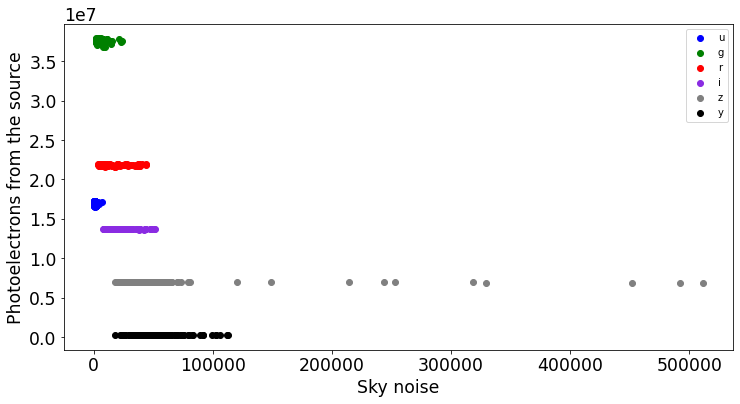

In [66]:
plt.scatter(N_pe_u, all_count_u, color = 'b', label = 'u')
plt.scatter(N_pe_g, all_count_g, color = 'g', label = 'g')
plt.scatter(N_pe_r, all_count_r, color = 'r', label = 'r')
plt.scatter(N_pe_i, all_count_i, color = 'blueviolet', label = 'i')
plt.scatter(N_pe_z, all_count_z, color = 'grey', label = 'z')
plt.scatter(N_pe_y, all_count_y, color = 'k', label = 'y')
plt.xlabel("Sky noise")
plt.ylabel("Photoelectrons from the source")
plt.legend()

In [67]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

In [68]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

In [128]:
tE = 50
u0 = 1
t0 = 61000

Amplitude = [[] for i in range (nbr_filters)]

for i in range (len(df)) :
    
    Amplitude[0].append(A(u(df["observationStartMJD"][i])))
    
    if df['filter'][i] == 'u' :

        Amplitude[1].append(A(u(df["observationStartMJD"][i])))
        
    if df['filter'][i] == 'g' :

        Amplitude[2].append(A(u(df["observationStartMJD"][i])))
        
    if df['filter'][i] == 'r' :

        Amplitude[3].append(A(u(df["observationStartMJD"][i])))
        
    if df['filter'][i] == 'i' :

        Amplitude[4].append(A(u(df["observationStartMJD"][i])))
        
    if df['filter'][i] == 'z' :

        Amplitude[5].append(A(u(df["observationStartMJD"][i])))
        
    if df['filter'][i] == 'y' :

        Amplitude[6].append(A(u(df["observationStartMJD"][i])))

# $F_{pe}$ = Source flux, $S_{pe}$ = Total flux

In [70]:
F_pe = [[] for i in range (nbr_filters)]

S_pe = [[] for i in range (nbr_filters)]

Flux_err = [[] for i in range (nbr_filters)]


for i in range (len(df)) :
    
    S_pe[0].append(all_count[i] * Amplitude[0][i])
    F_pe[0].append(S_pe[0][i] - N_pe[i])
    Flux_err[0].append(np.sqrt(F_pe[0][i]))
    
    if (df['filter'][i] == 'u') :
        
        F_pe[1].append(S_pe[0][i] - N_pe[i])
        S_pe[1].append(all_count[i] * Amplitude[0][i])
        Flux_err[1].append(np.sqrt(S_pe[0][i] - N_pe[i]))
               
    elif (df['filter'][i] == 'g') :
        
        F_pe[2].append(S_pe[0][i] - N_pe[i])
        S_pe[2].append(all_count[i] * Amplitude[0][i])
        Flux_err[2].append(np.sqrt(S_pe[0][i] - N_pe[i]))
    
    elif (df['filter'][i] == 'r') :
        
        F_pe[3].append(S_pe[0][i] - N_pe[i])
        S_pe[3].append(all_count[i] * Amplitude[0][i])
        Flux_err[3].append(np.sqrt(S_pe[0][i] - N_pe[i]))
       
    elif (df['filter'][i] == 'i') :
        
        F_pe[4].append(S_pe[0][i] - N_pe[i])
        S_pe[4].append(all_count[i] * Amplitude[0][i])
        Flux_err[4].append(np.sqrt(S_pe[0][i] - N_pe[i]))
    
    elif (df['filter'][i] == 'z') : 
        
        F_pe[5].append(S_pe[0][i] - N_pe[i])
        S_pe[5].append(all_count[i] * Amplitude[0][i])
        Flux_err[5].append(np.sqrt(S_pe[0][i] - N_pe[i]))
    
    elif (df['filter'][i] == 'y') :
        
        F_pe[6].append(S_pe[0][i] - N_pe[i])
        S_pe[6].append(all_count[i] * Amplitude[0][i])
        Flux_err[6].append(np.sqrt(S_pe[0][i] - N_pe[i]))
   


In [145]:
t0 = 61000

Sum_S_u = []
Sum_S_g = []
Sum_S_r = []
Sum_S_i = []
Sum_S_z = []
Sum_S_y = []
Sum_N_u = []
Sum_N_g = []
Sum_N_r = []
Sum_N_i = []
Sum_N_z = []
Sum_N_y = []


for i in range (len(all_count_u)) :
    
    if (abs(ObservationStartMJD_u[i] - t0) > 2*tE) :
        
        Sum_S_u.append(S_pe[1][i])
        Sum_N_u.append(N_pe_u[i])

        
S_moy_u = sum(Sum_S_u)/len(Sum_S_u)  # Valeur moyenne du flux total dans la bande u
N_moy_u = sum(Sum_N_u)/len(Sum_N_u)  # Valeur moyenne du bruit de fond dans la bande u 
F_min_u = S_moy_u - N_moy_u

for i in range (len(all_count_g)) :
    
    if (abs(ObservationStartMJD_g[i] - t0) > 2*tE) :
        
        Sum_S_g.append(S_pe[2][i])
        Sum_N_g.append(N_pe_g[i])
       
        
S_moy_g = sum(Sum_S_g)/len(Sum_S_g)  # Valeur moyenne du flux total dans la bande g
N_moy_g = sum(Sum_N_g)/len(Sum_N_g)  # Valeur moyenne du bruit de fond dans la bande g   
F_min_g = S_moy_g - N_moy_g
    
for i in range (len(all_count_r)) :
    
    if (abs(ObservationStartMJD_r[i] - t0) > 2*tE) :
        
        Sum_S_r.append(S_pe[3][i])
        Sum_N_r.append(N_pe_r[i])
       
        
S_moy_r = sum(Sum_S_r)/len(Sum_S_r)  # Valeur moyenne du flux total dans la bande r
N_moy_r = sum(Sum_N_r)/len(Sum_N_r)  # Valeur moyenne du bruit de fond dans la bande r   
F_min_r = S_moy_r - N_moy_r
    
for i in range (len(all_count_i)) :
    
    if (abs(ObservationStartMJD_i[i] - t0) > 2*tE) :
        
        Sum_S_i.append(S_pe[4][i])
        Sum_N_i.append(N_pe_i[i])
        
S_moy_i = sum(Sum_S_i)/len(Sum_S_i)  # Valeur moyenne du flux total dans la bande i
N_moy_i = sum(Sum_N_i)/len(Sum_N_i)  # Valeur moyenne du bruit de fond dans la bande i     
F_min_i = S_moy_i - N_moy_i
    
for i in range (len(all_count_z)) :
    
    if (abs(ObservationStartMJD_z[i] - t0) > 2*tE) :
        
        Sum_S_z.append(S_pe[5][i])
        Sum_N_z.append(N_pe_z[i])
       
        
S_moy_z = sum(Sum_S_z)/len(Sum_S_z)  # Valeur moyenne du flux total dans la bande z
N_moy_z = sum(Sum_N_z)/len(Sum_N_z)  # Valeur moyenne du bruit de fond dans la bande z   
F_min_z = S_moy_z - N_moy_z
    
for i in range (len(all_count_y)) :
    
    if (abs(ObservationStartMJD_y[i] - t0) > 2*tE) :
        
        Sum_S_y.append(S_pe[6][i])
        Sum_N_y.append(N_pe_y[i])
       
        
S_moy_y = sum(Sum_S_y)/len(Sum_S_y)  # Valeur moyenne du flux total dans la bande y
N_moy_y = sum(Sum_N_y)/len(Sum_N_y)  # Valeur moyenne du bruit de fond dans la bande y   
F_min_y = S_moy_y - N_moy_y

In [146]:
F_min_u

16951143.9762002

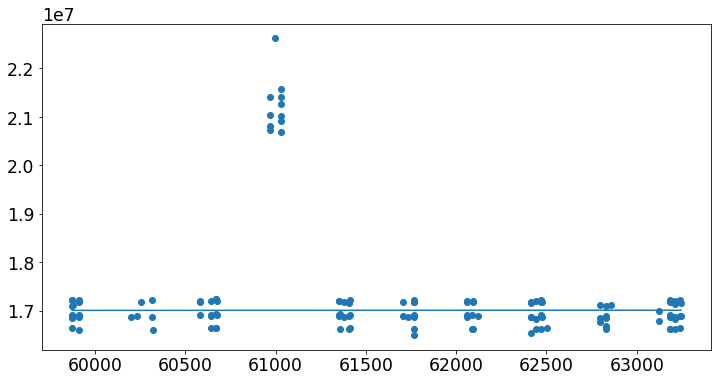

In [135]:
plt.scatter(ObservationStartMJD_u, F_pe[1])
plt.plot(ObservationStartMJD_u, linear(ObservationStartMJD_u, 1, F_min_u))

# Error on baseline flux

$$
    \sigma(F_{pe}^{bmin}) = \sqrt{(\frac{<S_{pe}>}{\sqrt{N}})^2 + (\frac{<N_{pe}>}{\sqrt{N}})^2}
$$

In [136]:
F_min_u_err = np.sqrt((S_moy_u/np.sqrt(len(Sum_S_u)))**2 + (N_moy_u/np.sqrt(len(N_pe_u)))**2)
F_min_g_err = np.sqrt((S_moy_g/np.sqrt(len(Sum_S_g)))**2 + (N_moy_g/np.sqrt(len(N_pe_g)))**2)
F_min_r_err = np.sqrt((S_moy_r/np.sqrt(len(Sum_S_r)))**2 + (N_moy_r/np.sqrt(len(N_pe_r)))**2)
F_min_i_err = np.sqrt((S_moy_i/np.sqrt(len(Sum_S_i)))**2 + (N_moy_i/np.sqrt(len(N_pe_i)))**2)
F_min_z_err = np.sqrt((S_moy_z/np.sqrt(len(Sum_S_z)))**2 + (N_moy_z/np.sqrt(len(N_pe_z)))**2)
F_min_y_err = np.sqrt((S_moy_y/np.sqrt(len(Sum_S_y)))**2 + (N_moy_y/np.sqrt(len(N_pe_y)))**2)

In [137]:
F_min_i_err/F_min_i

0.09774486554669923

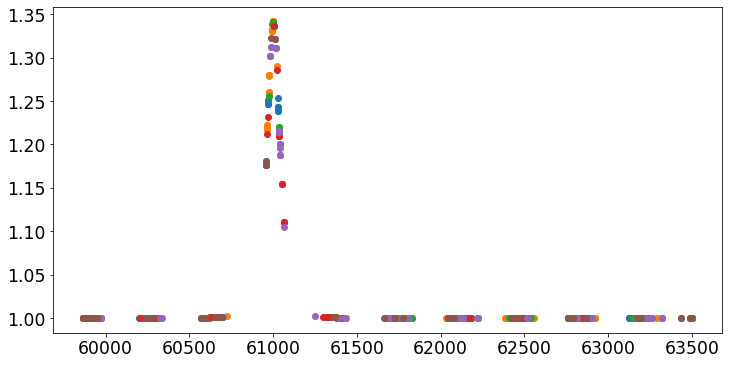

In [138]:
plt.scatter(ObservationStartMJD_u, Amplitude[1])
plt.scatter(ObservationStartMJD_g, Amplitude[2])
plt.scatter(ObservationStartMJD_r, Amplitude[3])
plt.scatter(ObservationStartMJD_i, Amplitude[4])
plt.scatter(ObservationStartMJD_z, Amplitude[5])
plt.scatter(ObservationStartMJD_y, Amplitude[6])

# Amplitude error

$$
    \sigma(A) = ( \frac{\sqrt{\sigma^2(S_{pe}^b) - \sigma^2(N_{pe}^b)}}{S_{pe}^b - N_{pe}^b} + \frac{\sigma(F_{pe}^{bmin})}{F_{pe}^{bmin}}) \times A
$$

In [142]:
amplitude_err = [[] for i in range (nbr_filters)]

for i in range (len(ObservationStartMJD_u)) :
    
    amplitude_err [1].append((Flux_err[1][i]/F_pe[1][i] + F_min_u_err/F_min_u) * Amplitude[1][i])
    
for i in range (len(ObservationStartMJD_g)) :
    
    amplitude_err[2].append((Flux_err[3][i]/F_pe[3][i] + F_min_g_err/F_min_g) * Amplitude[3][i])
    
for i in range (len(ObservationStartMJD_r)) :
    
    amplitude_err[3].append((Flux_err[3][i]/F_pe[3][i]**2 + F_min_r_err/F_min_r) * Amplitude[3][i])   

for i in range (len(ObservationStartMJD_i)) :
    
    amplitude_err[4].append((Flux_err[4][i]/F_pe[4][i] + F_min_i_err/F_min_i) * Amplitude[4][i])
    
for i in range (len(ObservationStartMJD_z)) :
    
    amplitude_err[5].append((Flux_err[5][i]/F_pe[5][i] + F_min_z_err/F_min_z) * Amplitude[5][i])
    
for i in range (len(ObservationStartMJD_y)) :
    
    amplitude_err[6].append((Flux_err[6][i]/F_pe[6][i] + F_min_y_err/F_min_y) * Amplitude[6][i])

<ErrorbarContainer object of 3 artists>

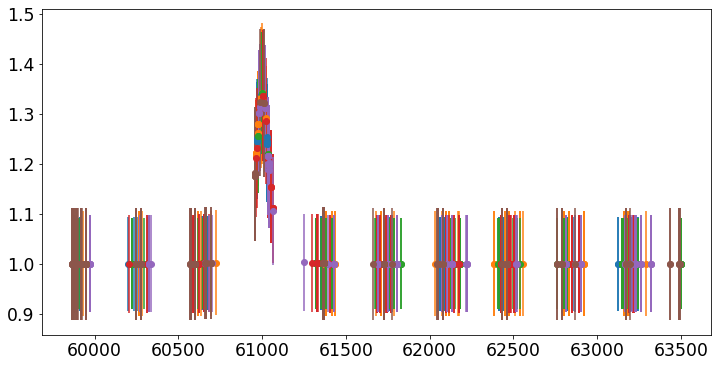

In [143]:
plt.errorbar(ObservationStartMJD_u, Amplitude[1], amplitude_err[1], fmt = "o")
plt.errorbar(ObservationStartMJD_g, Amplitude[2], amplitude_err[2], fmt = "o")
plt.errorbar(ObservationStartMJD_r, Amplitude[3], amplitude_err[3], fmt = "o")
plt.errorbar(ObservationStartMJD_i, Amplitude[4], amplitude_err[4], fmt = "o")
plt.errorbar(ObservationStartMJD_z, Amplitude[5], amplitude_err[5], fmt = "o")
plt.errorbar(ObservationStartMJD_y, Amplitude[6], amplitude_err[6], fmt = "o")

# Photometric error

$$
    N = \sqrt{N_{pe} + F}
$$

where 

$N_{pe}$ is the background noise 

F is the source flux  

N the photometric error

In [80]:
N = []
N_u = []
N_g = []
N_r = []
N_i = []
N_z = []
N_y = []

for i in range (len(bp_atmo)) :
    
    N.append(np.sqrt(N_pe[i] + all_count[i]))
    
for i in range (len(N_pe_u)) :
    
    N_u.append(np.sqrt(N_pe_u[i] + all_count_u[i]))
    
for i in range (len(N_pe_g)) :
    
    N_g.append(np.sqrt(N_pe_g[i] + all_count_g[i]))
    
for i in range (len(N_pe_r)) :
    
    N_r.append(np.sqrt(N_pe_r[i] + all_count_r[i]))
    
for i in range (len(N_pe_i)) :
    
    N_i.append(np.sqrt(N_pe_i[i] + all_count_i[i]))
    
for i in range (len(N_pe_z)) :
    
    N_z.append(np.sqrt(N_pe_z[i] + all_count_z[i]))
    
for i in range (len(N_pe_y)) :
    
    N_y.append(np.sqrt(N_pe_y[i] + all_count_y[i]))

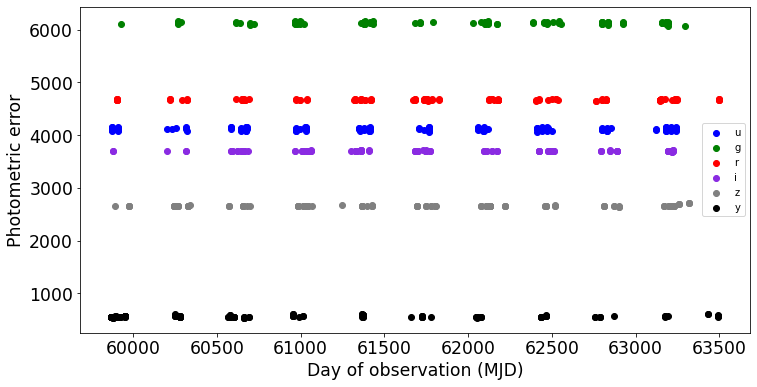

In [81]:
plt.scatter(ObservationStartMJD_u, N_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, N_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, N_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, N_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, N_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, N_y, color = 'k', label = 'y')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Photometric error")
plt.legend()

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the u band (with photometric errors)')

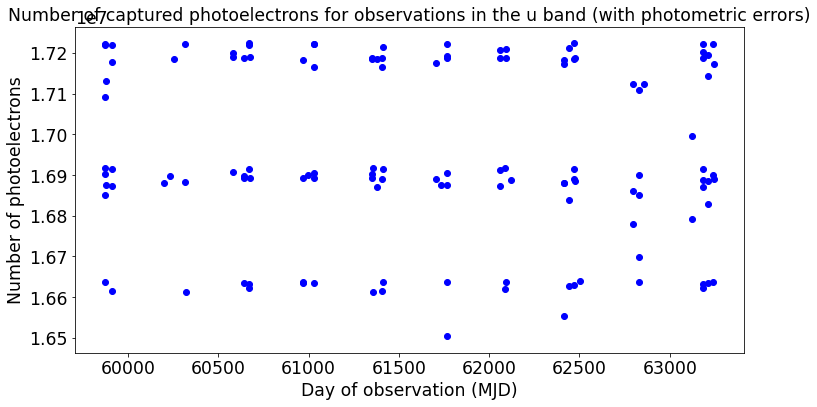

In [82]:
plt.errorbar(ObservationStartMJD_u, all_count_u, N_u, fmt="o", color = 'b')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the u band (with photometric errors)")

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the g band (with photometric errors)')

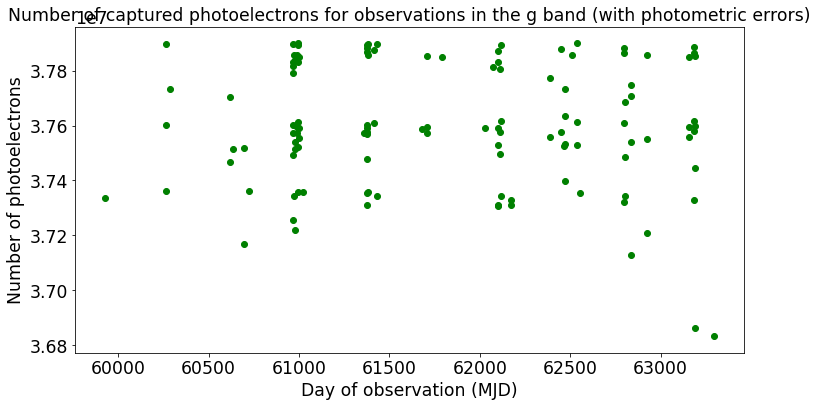

In [83]:
plt.errorbar(ObservationStartMJD_g, all_count_g, N_g, fmt="o", color = 'g')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the g band (with photometric errors)")

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the r band (with photometric errors)')

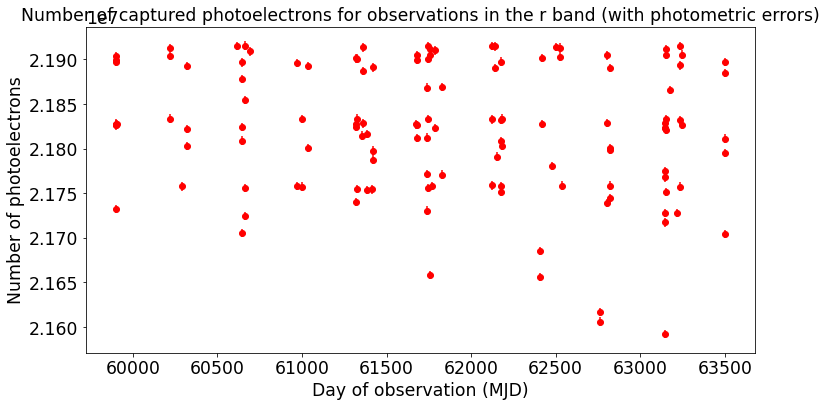

In [84]:
plt.errorbar(ObservationStartMJD_r, all_count_r, N_r, fmt="o", color = 'r')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the r band (with photometric errors)")

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the i band (with photometric errors)')

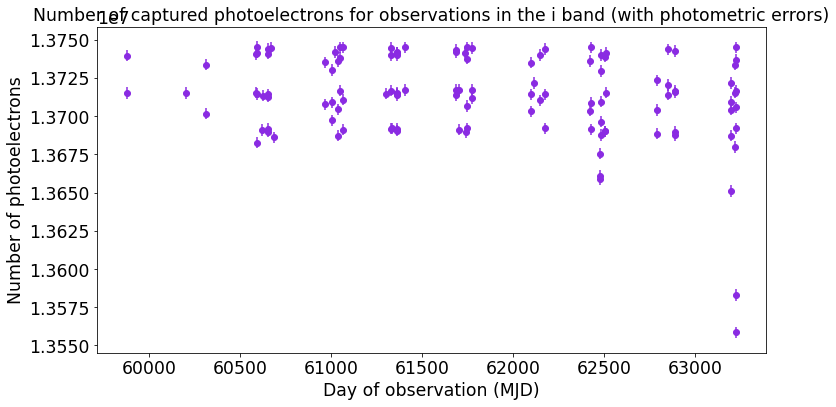

In [85]:
plt.errorbar(ObservationStartMJD_i, all_count_i, N_i, fmt="o", color = 'blueviolet')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the i band (with photometric errors)")

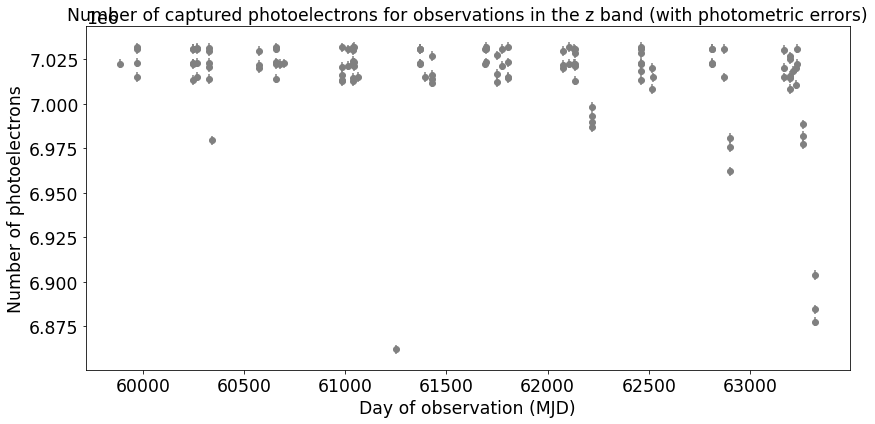

In [86]:
plt.errorbar(ObservationStartMJD_z, all_count_z, N_z, fmt="o", color = 'grey')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the z band (with photometric errors)")
plt.tight_layout()

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the y band (with photometric errors)')

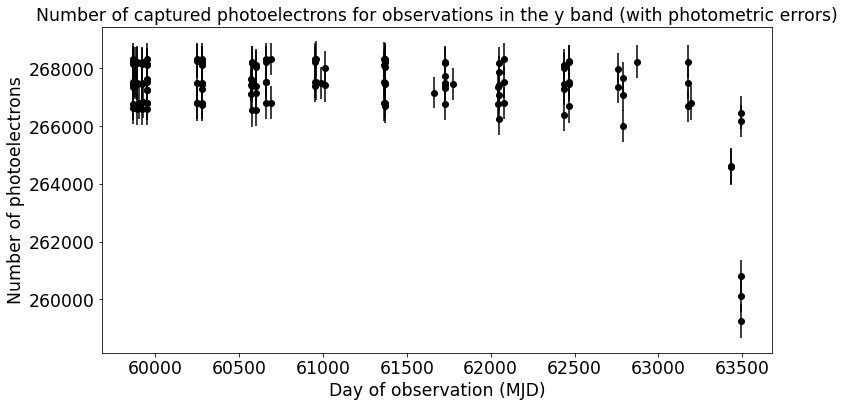

In [87]:
plt.errorbar(ObservationStartMJD_y, all_count_y, N_y, fmt="o", color = 'k')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the y band (with photometric errors)")

# Amplitude error

$$
\sigma_A = \frac{\sigma_N \times A(t)}{F}
$$

In [88]:
amp_err = []
amp_err_u = []
amp_err_g = []
amp_err_r = []
amp_err_i = []
amp_err_z = []
amp_err_y = []

for i in range (len(all_count)) :
    
    amp_err.append(N[i] * A(u(df['observationStartMJD'][i]))/all_count[i])

for i in range (len(all_count_u)) :
        
    amp_err_u.append(N_u[i] * A(u(ObservationStartMJD_u[i]))/all_count_u[i])
        
for i in range (len(all_count_g)) :
        
    amp_err_g.append(N_g[i] * A(u(ObservationStartMJD_g[i]))/all_count_g[i])
    
for i in range (len(all_count_r)) :
        
    amp_err_r.append(N_r[i] * A(u(ObservationStartMJD_r[i]))/all_count_r[i])
    
for i in range (len(all_count_i)) :
        
    amp_err_i.append(N_i[i] * A(u(ObservationStartMJD_i[i]))/all_count_i[i])
    
for i in range (len(all_count_z)) :
        
    amp_err_z.append(N_z[i] * A(u(ObservationStartMJD_z[i]))/all_count_z[i])
    
for i in range (len(all_count_y)) :
        
    amp_err_y.append(N_y[i] * A(u(ObservationStartMJD_y[i]))/all_count_y[i])


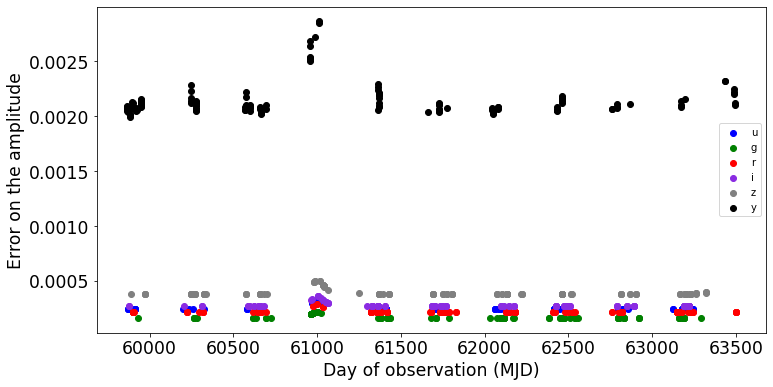

In [89]:
plt.scatter(ObservationStartMJD_u, amp_err_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, amp_err_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, amp_err_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, amp_err_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, amp_err_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, amp_err_y, color = 'k', label = 'y')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Error on the amplitude")
plt.legend()

# Plotting the light curve and Microlensing fit with expected errors

t0 = 61000
tE = 20
u0 = 1


(60900.0, 61100.0)

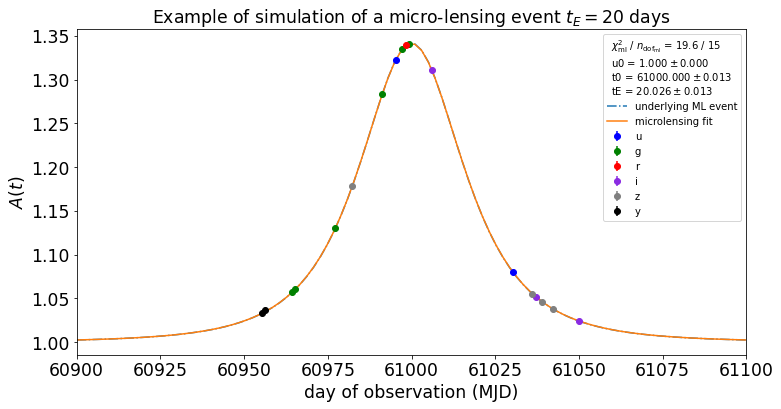

In [147]:
#Randomize parameters

from random import *

#u0 = umin[randrange(len(umin))]
#t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 20

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Photometric Error


    

amp_err = []
amp_err_u = []
amp_err_g = []
amp_err_r = []
amp_err_i = []
amp_err_z = []
amp_err_y = []

for i in range (len(df['observationStartMJD'])) :
    
    if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        amp_err.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
    
        if (df['filter'].values[i] == 'u') :
        
            
            amp_err_u.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
       
        if (df['filter'].values[i] == 'g') :
        
            
            amp_err_g.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'r') :
        
            
            amp_err_r.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'i') :
        
            
            amp_err_i.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'z') :
        
            
            amp_err_z.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'y') :
        
            
            amp_err_y.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
    



#Underlying ML event

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

y = y_data + amp_err * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + amp_err_u * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + amp_err_g * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + amp_err_r * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + amp_err_i * np.random.randn(len(x_i))
y_z = A(u(df_event_times_z)) + amp_err_z * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + amp_err_y * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")

least_squares = LeastSquares(x, y, amp_err, Ab)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Ab(ti, *m.values), label="microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

(60900.0, 61100.0)

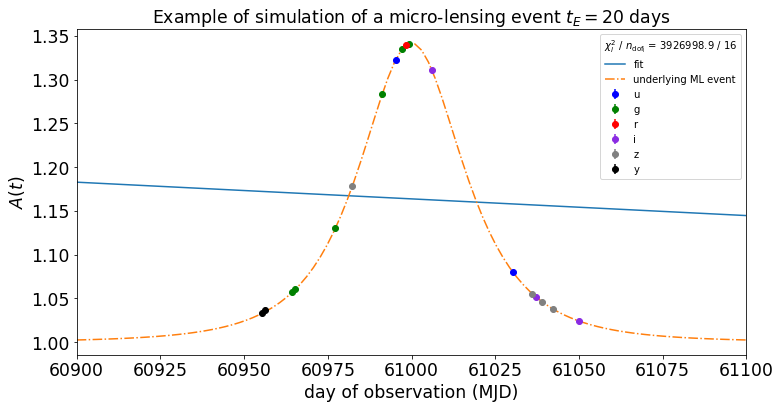

In [148]:
least_squares_line = LeastSquares(x, y, amp_err, linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label="fit")
plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [149]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit)) 

716965.034827993

In [93]:
t

OBJNAME,RA,DEC,SP_TYPE,SP_QUAL,magU,magB,magV,magR,magI,FILES,calcU,calcB,calcV,calcR,calcI,factor,VmI
bytes10,float64,float64,bytes12,bytes1,float64,float64,float64,float64,float64,bytes30,float64,float64,float64,float64,float64,float64,float64
NGC7293,337.411,-20.837,DAO.5,C,11.894,13.158,13.524,13.689,13.898,ngc7293_005.fits,11.917,13.180,13.538,13.734,14.234,26.01,-0.697
G93-48,328.106,2.389,DA2.8,C,11.942,12.732,12.743,12.839,12.938,g93_48_004.fits,11.982,12.717,12.728,12.836,13.234,12.34,-0.506
HZ4,58.842,9.788,DA3.4,C,13.917,14.592,14.506,14.580,14.642,hz4_stis_007.fits,13.923,14.587,14.472,14.561,14.718,61.484,-0.246
HD172167,279.235,38.784,A0Va,C,0.030,0.030,0.030,0.070,0.100,alpha_lyr_stis_010.fits,0.000,0.000,0.000,0.000,0.000,0.0001,0.000
HD163466,268.106,60.396,A2,E,100000000000000000000.000,7.040,6.850,100000000000000000000.000,100000000000000000000.000,hd163466_stis_005.fits,7.143,7.023,6.831,6.685,6.582,0.05399,0.249
HD101452,175.057,-39.147,A2/3(m)A8-F2,E,100000000000000000000.000,7.840,8.200,100000000000000000000.000,100000000000000000000.000,hd101452_stis_002.fits,7.898,7.809,7.508,7.289,7.142,0.10073,0.366
HD106252,183.373,10.042,G0,E,100000000000000000000.000,8.000,100000000000000000000.000,7.000,100000000000000000000.000,hd106252_stis_005.fits,8.101,8.007,7.394,6.948,6.646,0.090687,0.748
FLAT,0.000,0.000,flat,0,9.721,10.369,10.000,9.501,9.001,flat,9.721,10.369,10.000,9.501,9.001,1,0.999
